In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
plt.rcParams['figure.figsize'] = (16, 12)

# Cruise Ship Crew Requirements

You've been given a dataset describing various features of cruise ships such as their tonnage, total number of passengers, number of cabins etc. You've been asked to explore the dataset, present some summary statistics and (hopefully) build a model to calculate the number of crew required to staff a new ship. Again, you are asked to break the problem down into three stages

### Part 1: Exploration and Cleaning
1. Read in this data, clean and tidy if necessary.
1. Calculate basic statistics to understand what you have been given
1. Select some columns which might be correlated with price

### Part 2: Analysis and Model Building
1. Quantify correlations between columns
1. Create training and testing sets
1. Fit a model to predict crew requirements for new ships

### Part 3: Results
1. Summarize your findings

## Part 1

In [5]:
sCSV = 'https://m2pi.syzygy.ca/data/cruise_ship_info.csv'

sDF = pd.read_csv(sCSV)

In [6]:
sDF.head()

,Ship_name,Cruise_line,Age,Tonnage,passengers,length,cabins,passenger_density,crew
0,Journey,Azamara,6,30.277,6.94,5.94,3.55,42.64,3.55
1,Quest,Azamara,6,30.277,6.94,5.94,3.55,42.64,3.55
2,Celebration,Carnival,26,47.262,14.86,7.22,7.43,31.80,6.70
3,Conquest,Carnival,11,110.000,29.74,9.53,14.88,36.99,19.10
4,Destiny,Carnival,17,101.353,26.42,8.92,13.21,38.36,10.00


In [7]:
sDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158 entries, 0 to 157
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Ship_name          158 non-null    object 
 1   Cruise_line        158 non-null    object 
 2   Age                158 non-null    int64  
 3   Tonnage            158 non-null    float64
 4   passengers         158 non-null    float64
 5   length             158 non-null    float64
 6   cabins             158 non-null    float64
 7   passenger_density  158 non-null    float64
 8   crew               158 non-null    float64
dtypes: float64(6), int64(1), object(2)
memory usage: 11.2+ KB


Take a look at the numerical columns

In [8]:
sDF.describe()

,Age,Tonnage,passengers,length,cabins,passenger_density,crew
count,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000
mean,15.689873,71.284671,18.457405,8.130633,8.830000,39.900949,7.794177
std,7.615691,37.229540,9.677095,1.793474,4.471417,8.639217,3.503487
min,4.000000,2.329000,0.660000,2.790000,0.330000,17.700000,0.590000
25%,10.000000,46.013000,12.535000,7.100000,6.132500,34.570000,5.480000
50%,14.000000,71.899000,19.500000,8.555000,9.570000,39.085000,8.150000
75%,20.000000,90.772500,24.845000,9.510000,10.885000,44.185000,9.990000
max,48.000000,220.000000,54.000000,11.820000,27.000000,71.430000,21.000000


In [9]:
sDF.isna().sum(axis=0)

Ship_name            0
Cruise_line          0
Age                  0
Tonnage              0
passengers           0
length               0
cabins               0
passenger_density    0
crew                 0
dtype: int64

In [10]:
sDF.dtypes

Ship_name             object
Cruise_line           object
Age                    int64
Tonnage              float64
passengers           float64
length               float64
cabins               float64
passenger_density    float64
crew                 float64
dtype: object

I'm going to throw away the `Ship_name` then `Cruise_line` is my only categorical column, the rest are numeric. Let's explore the numeric ones

In [11]:
sDF.drop('Ship_name', axis=1, inplace=True)

### Distributions

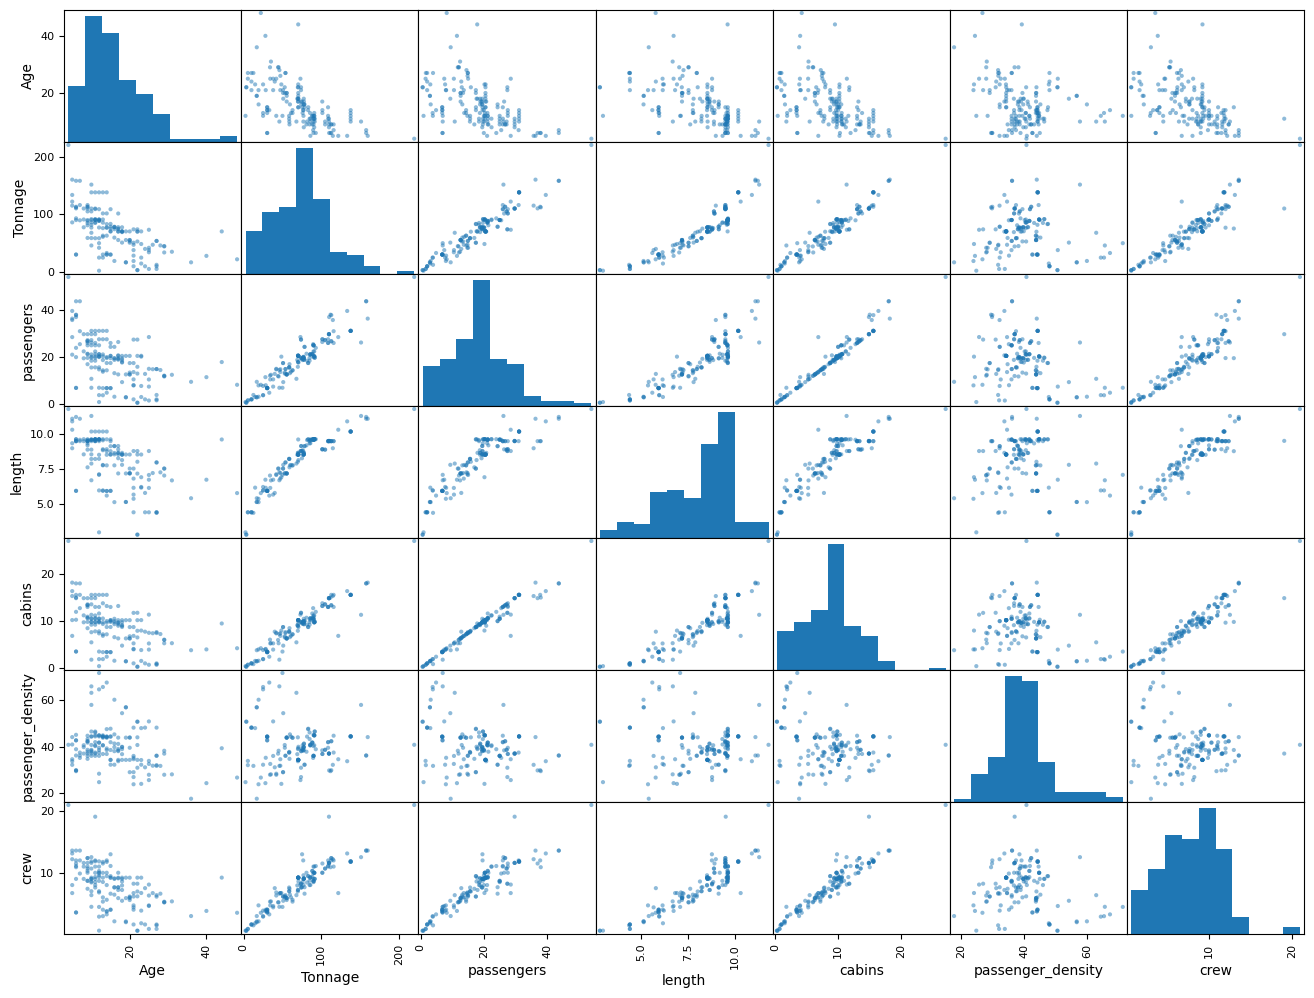

In [13]:
from pandas.plotting import scatter_matrix
cols = ['Age', 'Tonnage', 'passengers', 'length', 'cabins','passenger_density','crew']
scatter_matrix(sDF);

**LOTS** of really nice correlation

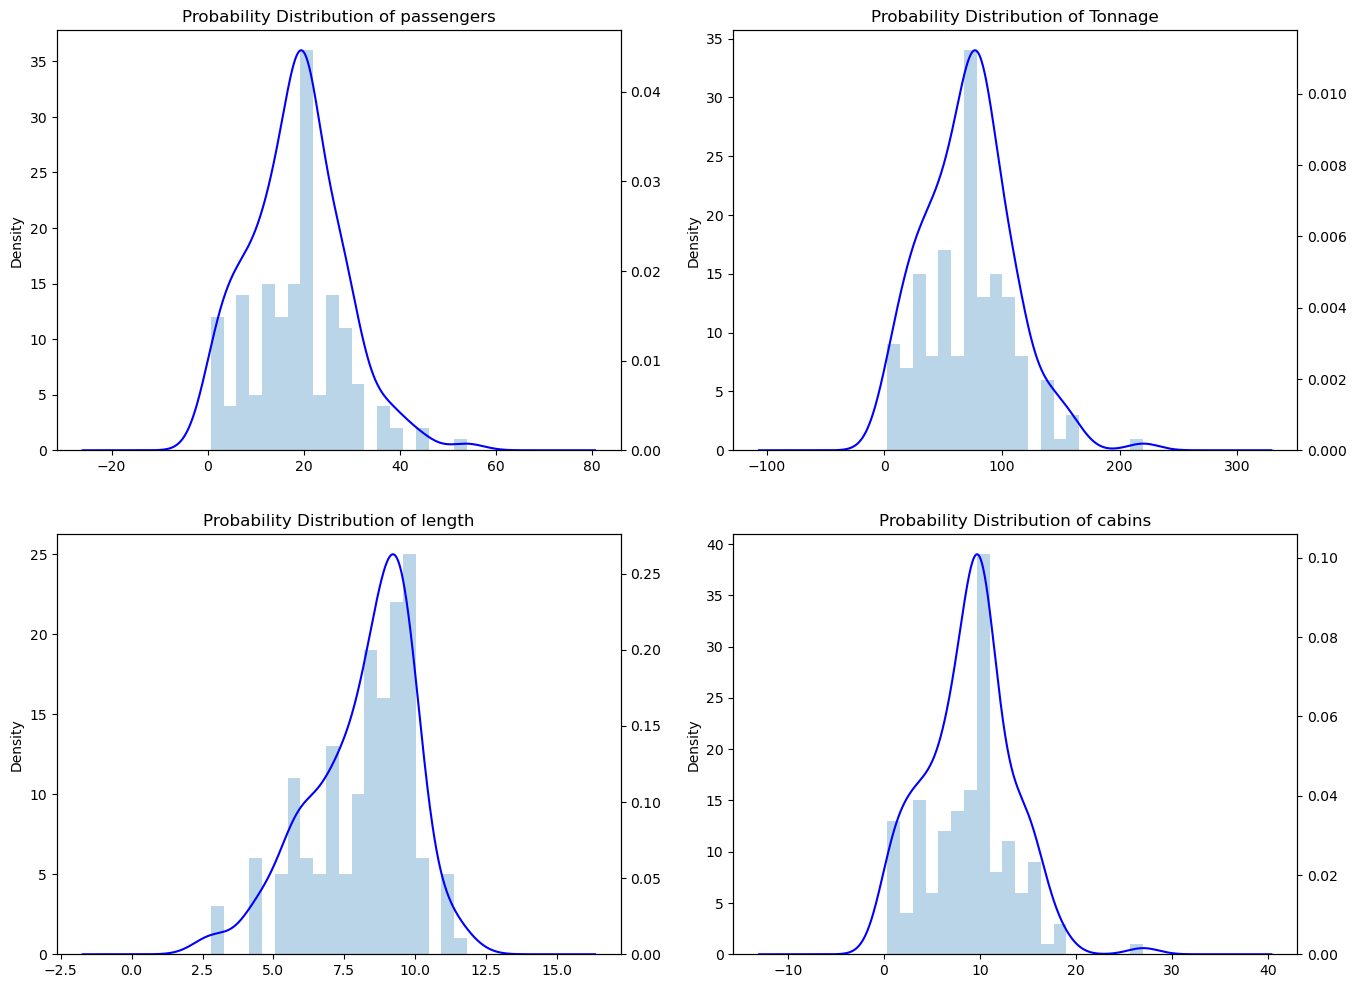

In [14]:
fig, axes = plt.subplots(2, 2)

features = ['passengers', 'Tonnage', 'length', 'cabins']

for i, feature in enumerate(features):
    ax = axes[i // 2, i % 2]
    sDF[feature].plot.hist(ax = ax, bins=20, alpha=0.3)
    sDF[feature].plot.kde(ax = ax, secondary_y=True, color='blue')
    ax.set_ylim(0)
    ax.right_ax.set_ylim(0)
    ax.set_title(f"Probability Distribution of {feature}")

The main conclusion I drew from these was that they were "normalish", I'd probably want to scale them, but other than that I was happy

### Correlations

Next I want to get a quick idea of which variables are correlated with each other

In [17]:
cor = sDF.corr(numeric_only=True)
cor

,Age,Tonnage,passengers,length,cabins,passenger_density,crew
Age,1.000000,-0.606646,-0.515542,-0.532286,-0.510019,-0.278830,-0.530657
Tonnage,-0.606646,1.000000,0.945061,0.922368,0.948764,-0.040846,0.927569
passengers,-0.515542,0.945061,1.000000,0.883535,0.976341,-0.294867,0.915234
length,-0.532286,0.922368,0.883535,1.000000,0.889798,-0.090488,0.895857
cabins,-0.510019,0.948764,0.976341,0.889798,1.000000,-0.253181,0.950823
passenger_density,-0.278830,-0.040846,-0.294867,-0.090488,-0.253181,1.000000,-0.155509
crew,-0.530657,0.927569,0.915234,0.895857,0.950823,-0.155509,1.000000


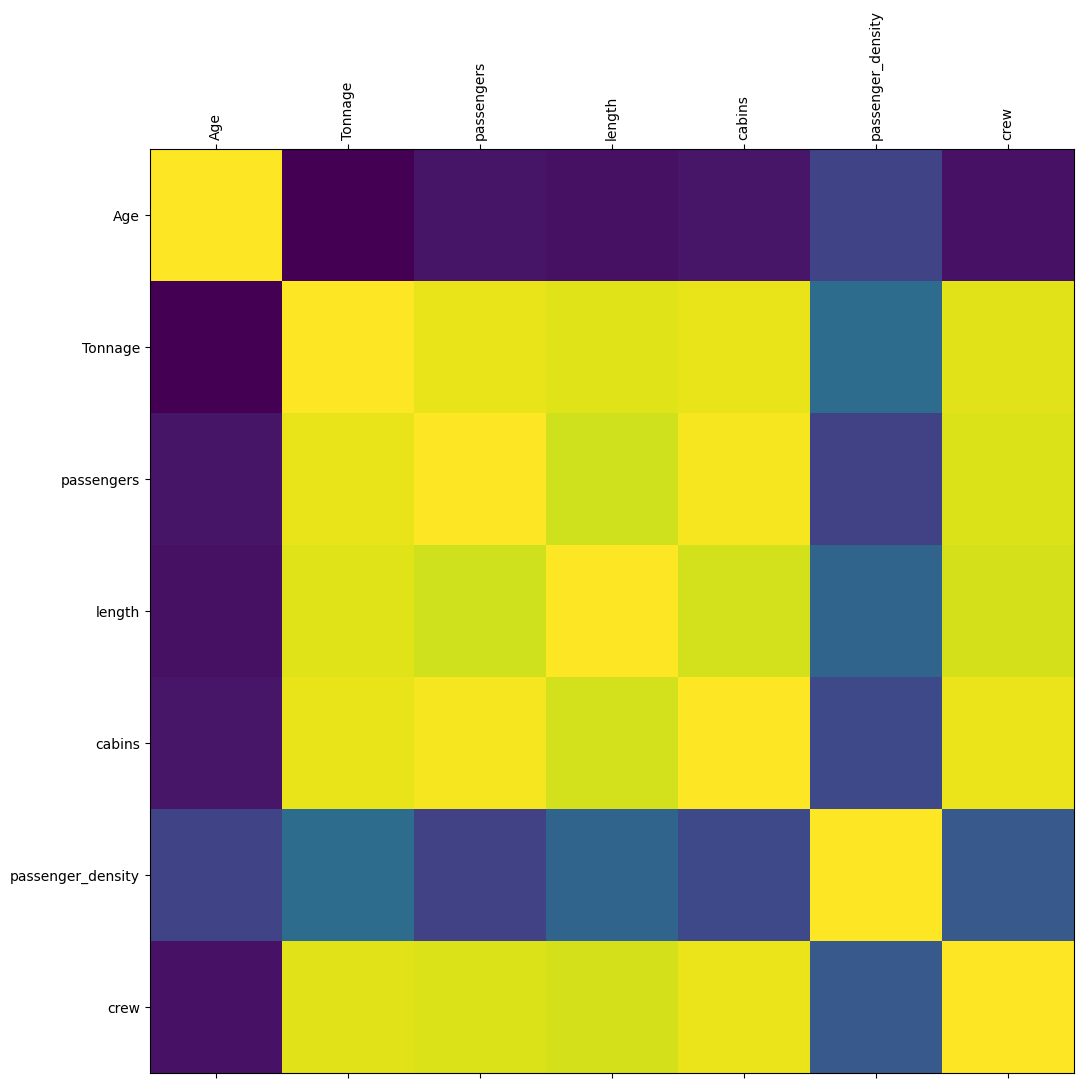

In [18]:
fig, ax = plt.subplots()
ax.matshow(
    cor,
    cmap='viridis'
)
ax.set_xticks(np.arange(len(cor.columns)));
ax.set_xticklabels(cor.columns, rotation=90);
ax.set_yticks(np.arange(len(cor.columns)));
ax.set_yticklabels(cor.columns);

In [19]:
sDF.cov(numeric_only=True)['crew']

Age                  -14.158696
Tonnage              120.985762
passengers            31.029706
length                 5.629035
cabins                14.895159
passenger_density     -4.706859
crew                  12.274418
Name: crew, dtype: float64

In [20]:
sDF.corr(numeric_only=True)['crew']

Age                 -0.530657
Tonnage              0.927569
passengers           0.915234
length               0.895857
cabins               0.950823
passenger_density   -0.155509
crew                 1.000000
Name: crew, dtype: float64

So crew size is strongly correlated with Tonnage, Passengers, length, and cabins

## Part 2

### Splitting the test and training data

**You are supposed to do this now, and leave your test data aside until the very end**

From above, if `Tonnage`, `Passengers`, `length` or `cabins` had a non-normal distribution, you should try to make sure that when we split the test and training data, we respect those distributions. `StratifiedShuffleSplit` can take the distribution into account when doing that sampling. Fortunately, those 4 columns look pretty normal so we'll just proceed

In [21]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    sDF.drop('crew', axis=1), 
    sDF['crew'], 
    test_size=0.2, 
    random_state=0
)

### Preprocessing

Use `StandardScaler` on all of the numerical columns and `OneHotEncoder` on the categorical ones

In [22]:
num_cols = ['Age', 'Tonnage', 'passengers', 'length', 'cabins','passenger_density']
cat_cols = ['Cruise_line']

To make these easier to use we can build a `ColumnTransformer` to apply them at the same time

In [23]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

transform = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(), cat_cols)
])

Now we can transform the whole training set (and the test dataset, when the time comes)

In [24]:
X_train_tr = transform.fit_transform(X_train)

### Training a model

With the preprocessing done, we are free to try out some models. Start with the `LinearRegression` model. It might be too simple, but it gets you oriented and is straightforwards so let's try.

In [25]:
from sklearn.linear_model import LinearRegression

In [26]:
model_lr = LinearRegression()

In [28]:
model_lr.fit(X_train_tr, y_train)
y_train_pred = model_lr.predict(X_train_tr)

In [29]:
from sklearn.metrics import mean_squared_error

mean_squared_error(y_train, model_lr.predict(X_train_tr))

0.730173879399999

You should stop and think to see if this is plausible. If not, what might have gone wrong, if so, what can you do to check

### What if your model won't train? Maybe try PCA

It looks OK, but there's room for improvement. Looking back at the original dataset, let's say you suspect that there is a lot of redundancy in the features. We could try chaining together a principal component analysis (PCA) and the linear regression to reduce the dimensionality the model has to deal with. For real world data, doing something like this might be a necessity rather than a cosmetic choice, and tools like `PCA` can help.

The practical point here is not the specific tools used, but rather that the consistent interfaces used by sklearn let us join them together (pipeline). Again, this isn't just a cosmetic choice, you're likely to want to search for hyperparameters and deal with cross validation so you'll need to build and apply your model many times. Having the whole thing packaged up in a pipeline really helps with this.

In [30]:
from sklearn.decomposition import PCA

pca = PCA()

X_train_num_pca = pca.fit_transform(X_train[num_cols], y_train)

The PCA class contains `explained_variance_ratio_` which returns the variance caused by each of the principal components

In [31]:
pca.explained_variance_ratio_

array([9.22636798e-01, 5.61208663e-02, 1.81104350e-02, 2.37572172e-03,
       4.65514908e-04, 2.90663742e-04])

This says that the last two principal components cause much less than 1% of the variance. Probably not worth dealing with, but let's retain the first 4 as components as an example

In [34]:
from sklearn.pipeline import Pipeline

num_pipeline = Pipeline([
    ('std_scaler', StandardScaler()),
    ('pca', PCA(n_components=4))
])

transform_full = ColumnTransformer([
    ('cat', OneHotEncoder(), cat_cols),
    ('num', num_pipeline, num_cols),
])

In [36]:
X_train_tr = transform_full.fit_transform(X_train)
model_lr = LinearRegression()
model_lr.fit(X_train_tr, y_train)

LinearRegression()

In [37]:
y_train_pred = model_lr.predict(X_train_tr)
mean_squared_error(y_train, y_train_pred)

0.9121991412178416

Better, but we should check to see if we're fooling ourselves

## Cross Validation

Before looking at the test data, we can try to determine how reliable this error is by calculating a cross validation score. In k-fold cross validation, the data is partitioned into k discrete sets. Each of these sets is held back in turn and used to test the model trained on the $k-1$ other folds. 

In [38]:
from sklearn.model_selection import cross_val_score

In [40]:
scores = cross_val_score(model_lr, X_train_tr, y_train,
                         scoring='neg_mean_squared_error', cv=10)
lin_rmse_scores = np.sqrt(-scores)

print(f"{lin_rmse_scores.mean()} += {lin_rmse_scores.std()}")

1.0200116281987568 += 0.5007395633875741


OK, so we should be able to say how many crew are needed to within 1 crew member.

## Other Models

Next we tried some other models with the same workflow

### Lasso

In [41]:
from sklearn.linear_model import Lasso
model_l = Lasso(alpha=0.7)

model_l.fit(X_train_tr,y_train)

scores = cross_val_score(model_l, X_train_tr, y_train,
                         scoring='neg_mean_squared_error', cv=10)
lasso_rmse_scores = np.sqrt(-scores)

print(f"{lasso_rmse_scores.mean()} += {lasso_rmse_scores.std()}")


1.2117648544726012 += 0.5096245993449965


In [42]:
from sklearn.model_selection import GridSearchCV

param_dist = {
    #'alpha':[1e-15,1e-10,1e-8,1e-3,1e-2,1,5,10,20,30,35,40,45,50,55,100],
    'alpha':[1e-4,1e-3,1e-2,1,5,10,20,30,35,40,45,50,55,100],
}
model_l = Lasso()
lr = GridSearchCV(model_l, param_dist, scoring='neg_mean_squared_error', cv=5)

lr.fit(X_train_tr, y_train)

GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 1, 5, 10, 20, 30, 35,
                                   40, 45, 50, 55, 100]},
             scoring='neg_mean_squared_error')

In [43]:
lr.best_params_

{'alpha': 0.01}

In [44]:
model_l = lr.best_estimator_

model_l.fit(X_train_tr,y_train)

scores = cross_val_score(model_l, X_train_tr, y_train,
                         scoring='neg_mean_squared_error', cv=10)
lasso_rmse_scores = np.sqrt(-scores)

print(f"{lasso_rmse_scores.mean()} += {lasso_rmse_scores.std()}")

0.9442883981109127 += 0.531092848839055


## Part 3

At this point, I we want to open the box and see how we do on the test data, but first we need to transform it

In [45]:
X_test_tr = transform_full.transform(X_test)

In [46]:
y_test_pred = model_l.predict(X_test_tr)
mean_squared_error(y_test, y_test_pred)

0.35784320046961565

/opt/conda/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


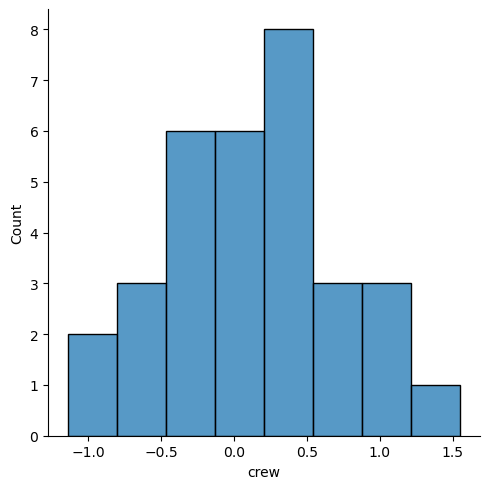

In [47]:
sns.displot(y_test - y_test_pred)

So the model performs pretty well on the test data too.